In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "classification_data/train_data/"
    testing_dir = "classification_data/test_data/"
    train_batch_size = 64
    train_number_epochs = 10 #100

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]==img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

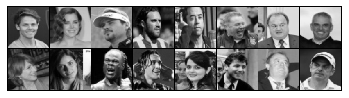

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        loss_contrastive = torch.mean((label) * euclidean_distance +
                                      (1-label) * torch.clamp(self.margin - euclidean_distance, min=0.0))


        return loss_contrastive

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [7]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.0192210674285889

Epoch number 0
 Current loss 0.7641186118125916

Epoch number 0
 Current loss 0.9267175197601318

Epoch number 0
 Current loss 0.7498818635940552

Epoch number 0
 Current loss 0.5560263395309448

Epoch number 0
 Current loss 0.6420250535011292

Epoch number 1
 Current loss 0.8514596223831177

Epoch number 1
 Current loss 0.7243802547454834

Epoch number 1
 Current loss 0.5809811353683472

Epoch number 1
 Current loss 0.9145312309265137

Epoch number 1
 Current loss 0.6317424774169922

Epoch number 1
 Current loss 0.6027190685272217

Epoch number 2
 Current loss 0.5475254058837891

Epoch number 2
 Current loss 0.7138453722000122

Epoch number 2
 Current loss 0.5386027097702026

Epoch number 2
 Current loss 0.5406889915466309

Epoch number 2
 Current loss 0.5577607154846191

Epoch number 2
 Current loss 0.5837796926498413

Epoch number 3
 Current loss 0.6798189878463745

Epoch number 3
 Current loss 0.5460017919540405

Epoch number 3
 Curr

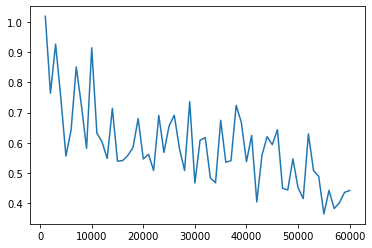

In [13]:
best_loss = float('inf')
for epoch in range(0,Config.train_number_epochs):
    epoch_loss = 0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        epoch_loss += loss_contrastive.item()
        if i %1000 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=1000
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    if epoch_loss < best_loss:     
        torch.save(net.state_dict(), "{}/hw2p2.pth".format('./weights/'))
        best_loss = epoch_loss
show_plot(counter,loss_history)

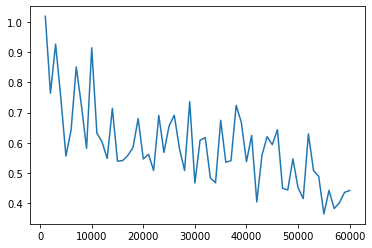

In [14]:
show_plot(counter,loss_history)

In [8]:
net.load_state_dict(torch.load('weights/hw2p2_009.pt'))

<All keys matched successfully>

tensor([[ 0.3256,  0.0449,  1.6495,  0.0385, -2.0571]], device='cuda:0',
       grad_fn=<AddmmBackward>) tensor([[ 0.1399, -0.0742,  1.6666, -0.0680,  0.1601]], device='cuda:0',
       grad_fn=<AddmmBackward>)


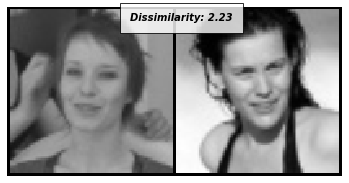

In [27]:
# img0 = Image.open('verification_data/00041961.jpg')
# img1 = Image.open('verification_data/00044353.jpg')

# img0 = Image.open('verification_data/00002921.jpg')
# img1 = Image.open('verification_data/00041331.jpg')

img0 = Image.open('verification_data/00060107.jpg')
img1 = Image.open('verification_data/00004843.jpg')

img0 = img0.convert("L")
img1 = img1.convert("L")
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
img0 = transform(img0)
img1 = transform(img1)

img0 = torch.unsqueeze(img0, 0)
img1 = torch.unsqueeze(img1, 0)
concatenated = torch.cat((img0,img1),0)
output1,output2 = net(Variable(img0).cuda(),Variable(img1).cuda())
print(output1, output2)
euclidean_distance = F.pairwise_distance(output1, output2)
imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [21]:
cos = nn.CosineSimilarity()
output = cos(output1, output2)
print("Similarity:", output.data)

Similarity: tensor([0.9999], device='cuda:0')


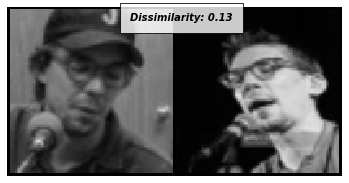

In [18]:
img0 = Image.open('verification_data/00007133.jpg')
img1 = Image.open('verification_data/00060449.jpg')

img0 = img0.convert("L")
img1 = img1.convert("L")
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
img0 = transform(img0)
img1 = transform(img1)

img0 = torch.unsqueeze(img0, 0)
img1 = torch.unsqueeze(img1, 0)
concatenated = torch.cat((img0,img1),0)
output1,output2 = net(Variable(img0).cuda(),Variable(img1).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)
imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [19]:
cos = nn.CosineSimilarity()
output = cos(output1, output2)
print("Similarity:", output.data)

Similarity: tensor([0.9999], device='cuda:0')


In [10]:
import pandas as pd

In [26]:
verify = pd.read_csv('verification_pairs_val.txt', delimiter=" ", header=None)
verify.head()

,0,1,2
0,verification_data/00041961.jpg,verification_data/00044353.jpg,0
1,verification_data/00007133.jpg,verification_data/00060449.jpg,1
2,verification_data/00041961.jpg,verification_data/00020166.jpg,0
3,verification_data/00013102.jpg,verification_data/00055525.jpg,1
4,verification_data/00002921.jpg,verification_data/00041331.jpg,0


In [34]:
correct = 0
for i in range(len(verify)):
    img0 = Image.open(verify[0][i])
    img1 = Image.open(verify[1][i])

    img0 = img0.convert("L")
    img1 = img1.convert("L")
    transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    img0 = transform(img0)
    img1 = transform(img1)

    img0 = torch.unsqueeze(img0, 0)
    img1 = torch.unsqueeze(img1, 0)
    concatenated = torch.cat((img0,img1),0)
    output1,output2 = net(Variable(img0).cuda(),Variable(img1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance.item() > 0.20:
        pred = 0
    else:
        pred = 1
        
    if pred == verify[2][i]:
        correct += 1
    else:
        print(verify[0][i], verify[1][i], verify[2][i], euclidean_distance.item())
    
print("Accuracy: ", correct/len(verify))

verification_data/00041961.jpg verification_data/00044353.jpg 0 0.028193091973662376
verification_data/00013102.jpg verification_data/00055525.jpg 1 0.6234434247016907
verification_data/00002921.jpg verification_data/00041331.jpg 0 0.12751223146915436
verification_data/00015978.jpg verification_data/00060526.jpg 1 0.23678484559059143
verification_data/00067262.jpg verification_data/00028237.jpg 1 1.1386768817901611
verification_data/00030649.jpg verification_data/00002786.jpg 1 0.7655475735664368
verification_data/00026074.jpg verification_data/00026286.jpg 1 0.2049824744462967
verification_data/00060107.jpg verification_data/00020369.jpg 0 0.15767212212085724
verification_data/00011732.jpg verification_data/00021648.jpg 0 0.051084838807582855
verification_data/00055250.jpg verification_data/00032543.jpg 1 0.37916824221611023
verification_data/00011732.jpg verification_data/00058189.jpg 0 0.12225837260484695
verification_data/00060107.jpg verification_data/00045886.jpg 0 0.125470712780

verification_data/00007142.jpg verification_data/00001560.jpg 1 0.8942148685455322
verification_data/00057472.jpg verification_data/00065779.jpg 1 1.93550443649292
verification_data/00028971.jpg verification_data/00065911.jpg 1 1.529579997062683
verification_data/00046029.jpg verification_data/00017145.jpg 1 1.0414425134658813
verification_data/00032040.jpg verification_data/00024907.jpg 1 1.7681149244308472
verification_data/00010728.jpg verification_data/00044047.jpg 1 1.7433220148086548
verification_data/00008842.jpg verification_data/00033814.jpg 1 1.2961825132369995
verification_data/00037063.jpg verification_data/00056666.jpg 0 0.16508056223392487
verification_data/00030793.jpg verification_data/00015262.jpg 1 0.6998825669288635
verification_data/00008231.jpg verification_data/00066083.jpg 1 0.21028470993041992
verification_data/00016416.jpg verification_data/00036111.jpg 1 0.629275381565094
verification_data/00038318.jpg verification_data/00062438.jpg 1 0.6823852062225342
verifi

verification_data/00003976.jpg verification_data/00051853.jpg 1 2.4437332153320312
verification_data/00056945.jpg verification_data/00021207.jpg 1 0.43514832854270935
verification_data/00039536.jpg verification_data/00023032.jpg 1 2.0103302001953125
verification_data/00012212.jpg verification_data/00020537.jpg 1 2.0176665782928467
verification_data/00035398.jpg verification_data/00001428.jpg 1 1.4261457920074463
verification_data/00002921.jpg verification_data/00026041.jpg 0 0.1519678384065628
verification_data/00049792.jpg verification_data/00015859.jpg 1 0.27317094802856445
verification_data/00006870.jpg verification_data/00057225.jpg 1 0.20960447192192078
verification_data/00020629.jpg verification_data/00018274.jpg 1 1.5327699184417725
verification_data/00012369.jpg verification_data/00052557.jpg 1 1.3608787059783936
verification_data/00023096.jpg verification_data/00025434.jpg 1 0.45473748445510864
verification_data/00043947.jpg verification_data/00065954.jpg 1 2.052611827850342
v

verification_data/00041961.jpg verification_data/00022453.jpg 0 0.051755137741565704
verification_data/00007550.jpg verification_data/00032684.jpg 1 1.9924663305282593
verification_data/00067522.jpg verification_data/00008964.jpg 1 0.34577226638793945
verification_data/00063269.jpg verification_data/00031191.jpg 1 1.9823352098464966
verification_data/00037063.jpg verification_data/00028388.jpg 0 0.16104276478290558
verification_data/00060107.jpg verification_data/00011755.jpg 0 0.055387526750564575
verification_data/00033206.jpg verification_data/00051217.jpg 1 0.7932635545730591
verification_data/00046783.jpg verification_data/00032286.jpg 0 0.10209298133850098
verification_data/00037063.jpg verification_data/00035030.jpg 0 0.054943349212408066
verification_data/00063612.jpg verification_data/00025038.jpg 1 1.3368514776229858
verification_data/00011732.jpg verification_data/00066842.jpg 0 0.07705097645521164
verification_data/00041961.jpg verification_data/00061543.jpg 0 0.07366232573

verification_data/00067416.jpg verification_data/00012677.jpg 1 0.20263512432575226
verification_data/00052491.jpg verification_data/00065711.jpg 1 0.44641223549842834
verification_data/00002921.jpg verification_data/00041121.jpg 0 0.17856326699256897
verification_data/00067902.jpg verification_data/00053057.jpg 1 1.4535871744155884
verification_data/00056417.jpg verification_data/00015870.jpg 1 1.9157135486602783
verification_data/00046783.jpg verification_data/00034389.jpg 0 0.12093100696802139
verification_data/00011732.jpg verification_data/00009197.jpg 0 0.06722135096788406
verification_data/00037063.jpg verification_data/00019429.jpg 0 0.05358361080288887
verification_data/00037063.jpg verification_data/00025559.jpg 0 0.10204341262578964
verification_data/00004713.jpg verification_data/00026342.jpg 1 0.22580114006996155
verification_data/00037063.jpg verification_data/00068283.jpg 0 0.15605869889259338
verification_data/00011732.jpg verification_data/00007860.jpg 0 0.128397911787

verification_data/00046783.jpg verification_data/00043136.jpg 0 0.0707828626036644
verification_data/00050254.jpg verification_data/00002068.jpg 1 1.0023226737976074
verification_data/00005298.jpg verification_data/00060677.jpg 1 2.2325851917266846
verification_data/00011732.jpg verification_data/00023406.jpg 0 0.1529361605644226
verification_data/00060107.jpg verification_data/00024460.jpg 0 0.18110114336013794
verification_data/00037063.jpg verification_data/00024170.jpg 0 0.07495582103729248
verification_data/00010972.jpg verification_data/00005515.jpg 1 1.9524354934692383
verification_data/00063370.jpg verification_data/00067172.jpg 1 0.4515128433704376
verification_data/00061232.jpg verification_data/00016299.jpg 1 0.898880124092102
verification_data/00002921.jpg verification_data/00027762.jpg 0 0.06146469712257385
verification_data/00046906.jpg verification_data/00051471.jpg 1 0.5642119646072388
verification_data/00037063.jpg verification_data/00060072.jpg 0 0.08260917663574219
v

verification_data/00034479.jpg verification_data/00062644.jpg 1 0.47348135709762573
verification_data/00047929.jpg verification_data/00038783.jpg 1 0.2270057201385498
verification_data/00018721.jpg verification_data/00040545.jpg 1 2.0336039066314697
verification_data/00015796.jpg verification_data/00035082.jpg 1 1.0195297002792358
verification_data/00041961.jpg verification_data/00059077.jpg 0 0.0005640218732878566
verification_data/00019106.jpg verification_data/00046462.jpg 1 0.25884369015693665
verification_data/00060107.jpg verification_data/00053459.jpg 0 0.13692814111709595
verification_data/00002907.jpg verification_data/00034130.jpg 1 0.3539573550224304
verification_data/00041961.jpg verification_data/00025624.jpg 0 0.005076620727777481
verification_data/00037063.jpg verification_data/00025543.jpg 0 0.16211208701133728
verification_data/00060107.jpg verification_data/00048925.jpg 0 0.140062153339386
verification_data/00048806.jpg verification_data/00003037.jpg 1 0.8546807765960

verification_data/00000821.jpg verification_data/00015716.jpg 1 1.8757586479187012
verification_data/00041961.jpg verification_data/00055819.jpg 0 0.008691900409758091
verification_data/00059247.jpg verification_data/00049828.jpg 1 1.7460734844207764
verification_data/00062489.jpg verification_data/00039250.jpg 1 2.0707850456237793
verification_data/00000639.jpg verification_data/00023492.jpg 1 1.4894639253616333
verification_data/00042027.jpg verification_data/00032088.jpg 1 0.5472053289413452
verification_data/00011732.jpg verification_data/00041558.jpg 0 0.06697530299425125
verification_data/00059479.jpg verification_data/00004688.jpg 1 1.759490966796875
verification_data/00037063.jpg verification_data/00036975.jpg 0 0.030168425291776657
verification_data/00052987.jpg verification_data/00022223.jpg 1 0.2393188327550888
verification_data/00011222.jpg verification_data/00005501.jpg 1 1.92605459690094
verification_data/00019944.jpg verification_data/00067905.jpg 1 0.5770878195762634
ve

verification_data/00042256.jpg verification_data/00055658.jpg 1 0.2688637375831604
verification_data/00058056.jpg verification_data/00068265.jpg 1 0.24434204399585724
verification_data/00065395.jpg verification_data/00010359.jpg 1 1.3442777395248413
verification_data/00000086.jpg verification_data/00007538.jpg 1 1.4962483644485474
verification_data/00054314.jpg verification_data/00028856.jpg 1 2.5326449871063232
verification_data/00031952.jpg verification_data/00013444.jpg 1 0.38532206416130066
verification_data/00046783.jpg verification_data/00014425.jpg 0 0.17557434737682343
verification_data/00041961.jpg verification_data/00008221.jpg 0 0.009843060746788979
verification_data/00041961.jpg verification_data/00053303.jpg 0 0.06723182648420334
verification_data/00024849.jpg verification_data/00021985.jpg 1 1.068267822265625
verification_data/00030018.jpg verification_data/00053630.jpg 1 0.22385573387145996
verification_data/00062693.jpg verification_data/00031839.jpg 1 0.722846150398254

verification_data/00035937.jpg verification_data/00013765.jpg 1 0.752951443195343
verification_data/00011732.jpg verification_data/00011749.jpg 0 0.14587189257144928
verification_data/00037063.jpg verification_data/00066909.jpg 0 0.021553466096520424
verification_data/00054635.jpg verification_data/00066150.jpg 1 2.1750869750976562
verification_data/00058189.jpg verification_data/00061371.jpg 1 0.31511208415031433
verification_data/00042385.jpg verification_data/00015013.jpg 1 2.1298890113830566
verification_data/00037063.jpg verification_data/00009868.jpg 0 0.037990741431713104
verification_data/00044366.jpg verification_data/00001914.jpg 1 2.144092321395874
verification_data/00018569.jpg verification_data/00008810.jpg 1 1.190865159034729
verification_data/00046783.jpg verification_data/00065001.jpg 0 0.18956652283668518
verification_data/00006234.jpg verification_data/00012401.jpg 1 0.7902055978775024
verification_data/00054049.jpg verification_data/00022191.jpg 1 1.4501724243164062


verification_data/00037063.jpg verification_data/00031428.jpg 0 0.052027326077222824
verification_data/00053503.jpg verification_data/00013628.jpg 1 0.22420908510684967
verification_data/00024379.jpg verification_data/00027880.jpg 1 2.087395191192627
verification_data/00066973.jpg verification_data/00037584.jpg 1 1.2886379957199097
verification_data/00046783.jpg verification_data/00017596.jpg 0 0.16537323594093323
verification_data/00067012.jpg verification_data/00009826.jpg 1 0.2833297848701477
verification_data/00049202.jpg verification_data/00054359.jpg 1 2.133878231048584
verification_data/00032507.jpg verification_data/00001673.jpg 1 1.4622873067855835
verification_data/00041961.jpg verification_data/00030946.jpg 0 0.0785592719912529
verification_data/00063541.jpg verification_data/00043787.jpg 1 1.9433180093765259
verification_data/00011732.jpg verification_data/00052465.jpg 0 0.0893452912569046
verification_data/00024627.jpg verification_data/00059716.jpg 1 0.22473187744617462
v

verification_data/00014046.jpg verification_data/00006228.jpg 1 1.8885248899459839
verification_data/00036945.jpg verification_data/00033323.jpg 1 2.0152597427368164
verification_data/00063063.jpg verification_data/00013719.jpg 1 2.0524520874023438
verification_data/00011122.jpg verification_data/00047369.jpg 1 1.4917019605636597
verification_data/00042952.jpg verification_data/00065498.jpg 1 0.22518682479858398
verification_data/00022563.jpg verification_data/00003444.jpg 1 1.0478148460388184
verification_data/00041961.jpg verification_data/00040522.jpg 0 0.033448923379182816
verification_data/00015274.jpg verification_data/00037232.jpg 1 2.1308705806732178
verification_data/00000050.jpg verification_data/00036793.jpg 1 1.6255983114242554
verification_data/00046783.jpg verification_data/00014836.jpg 0 0.14497512578964233
verification_data/00020986.jpg verification_data/00059042.jpg 1 1.8846312761306763
verification_data/00061776.jpg verification_data/00048193.jpg 1 1.7913224697113037


verification_data/00037063.jpg verification_data/00036389.jpg 0 0.1929929256439209
verification_data/00037063.jpg verification_data/00014694.jpg 0 0.03424445912241936
verification_data/00048377.jpg verification_data/00058953.jpg 1 1.4720486402511597
verification_data/00002921.jpg verification_data/00044552.jpg 0 0.18098413944244385
verification_data/00011732.jpg verification_data/00045126.jpg 0 0.03240259364247322
verification_data/00008371.jpg verification_data/00047845.jpg 1 0.3838576674461365
verification_data/00053342.jpg verification_data/00061796.jpg 1 0.43023911118507385
verification_data/00002921.jpg verification_data/00000587.jpg 0 0.06338264048099518
verification_data/00014980.jpg verification_data/00057032.jpg 1 1.7053848505020142
verification_data/00011732.jpg verification_data/00031575.jpg 0 0.06519445776939392
verification_data/00039739.jpg verification_data/00003180.jpg 1 0.20143914222717285
verification_data/00033864.jpg verification_data/00010802.jpg 1 0.60603982210159

verification_data/00020275.jpg verification_data/00049584.jpg 1 1.5585368871688843
verification_data/00013365.jpg verification_data/00065343.jpg 1 1.3585522174835205
verification_data/00025425.jpg verification_data/00051307.jpg 1 1.7918598651885986
verification_data/00055459.jpg verification_data/00058295.jpg 1 0.35553792119026184
verification_data/00011951.jpg verification_data/00065088.jpg 1 1.60482656955719
verification_data/00041961.jpg verification_data/00030857.jpg 0 0.0258417259901762
verification_data/00060107.jpg verification_data/00003217.jpg 0 0.12673121690750122
verification_data/00062296.jpg verification_data/00009944.jpg 1 0.8328869938850403
verification_data/00038067.jpg verification_data/00032962.jpg 1 2.6376564502716064
verification_data/00012807.jpg verification_data/00007299.jpg 1 2.2714614868164062
verification_data/00006994.jpg verification_data/00029515.jpg 1 1.8774503469467163
verification_data/00010374.jpg verification_data/00061697.jpg 1 0.5061114430427551
veri

verification_data/00043499.jpg verification_data/00032114.jpg 1 0.6775198578834534
verification_data/00040201.jpg verification_data/00041697.jpg 1 1.2345060110092163
verification_data/00063799.jpg verification_data/00037980.jpg 1 1.9332311153411865
verification_data/00005118.jpg verification_data/00052558.jpg 1 0.7169733643531799
verification_data/00041961.jpg verification_data/00026016.jpg 0 0.029804563149809837
verification_data/00018980.jpg verification_data/00060772.jpg 1 1.1171770095825195
verification_data/00008869.jpg verification_data/00018029.jpg 1 1.172884464263916
verification_data/00018293.jpg verification_data/00021179.jpg 1 0.326303094625473
verification_data/00019398.jpg verification_data/00040494.jpg 1 0.9204778075218201
verification_data/00041961.jpg verification_data/00014664.jpg 0 0.03841087222099304
verification_data/00060107.jpg verification_data/00060298.jpg 0 0.14206039905548096
verification_data/00052328.jpg verification_data/00068165.jpg 1 0.26930245757102966
v

verification_data/00019021.jpg verification_data/00061058.jpg 1 0.4134996235370636
verification_data/00058064.jpg verification_data/00017509.jpg 1 1.8999948501586914
verification_data/00035742.jpg verification_data/00016549.jpg 1 2.013947010040283
verification_data/00038379.jpg verification_data/00035464.jpg 1 2.0993900299072266
verification_data/00068756.jpg verification_data/00001657.jpg 1 1.326975703239441
verification_data/00062923.jpg verification_data/00066606.jpg 1 2.3794281482696533
verification_data/00041961.jpg verification_data/00068212.jpg 0 0.03550637140870094
verification_data/00063034.jpg verification_data/00044565.jpg 1 2.1004767417907715
verification_data/00060977.jpg verification_data/00067844.jpg 1 0.2153814435005188
verification_data/00037063.jpg verification_data/00060739.jpg 0 0.02178017422556877
verification_data/00003309.jpg verification_data/00052472.jpg 1 0.22904011607170105
verification_data/00034311.jpg verification_data/00044930.jpg 1 0.9331058263778687
ver

verification_data/00041961.jpg verification_data/00045232.jpg 0 0.10968349874019623
verification_data/00000102.jpg verification_data/00064105.jpg 1 1.8758336305618286
verification_data/00002921.jpg verification_data/00049504.jpg 0 0.09659863263368607
verification_data/00050923.jpg verification_data/00045159.jpg 1 0.3546748161315918
verification_data/00037063.jpg verification_data/00054437.jpg 0 0.05091680586338043
verification_data/00020004.jpg verification_data/00040063.jpg 1 1.996684193611145
verification_data/00001103.jpg verification_data/00019377.jpg 1 1.8308850526809692
verification_data/00011732.jpg verification_data/00013158.jpg 0 0.07460543513298035
verification_data/00006295.jpg verification_data/00046408.jpg 1 1.6671998500823975
verification_data/00024460.jpg verification_data/00057387.jpg 1 2.1028027534484863
verification_data/00002921.jpg verification_data/00064764.jpg 0 0.13350744545459747
verification_data/00031954.jpg verification_data/00032529.jpg 1 1.8971604108810425


verification_data/00016169.jpg verification_data/00050074.jpg 1 1.5187562704086304
verification_data/00051481.jpg verification_data/00040832.jpg 1 0.4778774380683899
verification_data/00007640.jpg verification_data/00053749.jpg 1 1.3271390199661255
verification_data/00065994.jpg verification_data/00025120.jpg 1 1.6852608919143677
verification_data/00031592.jpg verification_data/00006687.jpg 1 2.205703020095825
verification_data/00057488.jpg verification_data/00039407.jpg 1 0.5111879706382751
verification_data/00004653.jpg verification_data/00045331.jpg 1 2.403430461883545
verification_data/00002921.jpg verification_data/00018843.jpg 0 0.043059341609478
verification_data/00061962.jpg verification_data/00042974.jpg 1 2.158022165298462
verification_data/00025709.jpg verification_data/00053048.jpg 1 0.2358107715845108
verification_data/00008494.jpg verification_data/00024432.jpg 1 1.647735357284546
verification_data/00002921.jpg verification_data/00000821.jpg 0 0.15220201015472412
verifica

verification_data/00056110.jpg verification_data/00047182.jpg 1 0.831500768661499
verification_data/00041522.jpg verification_data/00037488.jpg 1 2.0068857669830322
verification_data/00002921.jpg verification_data/00025312.jpg 0 0.0988021194934845
verification_data/00046432.jpg verification_data/00039907.jpg 1 1.5348361730575562
verification_data/00011732.jpg verification_data/00001606.jpg 0 0.1808968335390091
verification_data/00060107.jpg verification_data/00022447.jpg 0 0.15810346603393555
verification_data/00037063.jpg verification_data/00033506.jpg 0 0.08170033991336823
verification_data/00041961.jpg verification_data/00035810.jpg 0 0.06123834848403931
verification_data/00067134.jpg verification_data/00055431.jpg 1 1.939608097076416
verification_data/00066683.jpg verification_data/00009938.jpg 1 1.9640123844146729
verification_data/00043070.jpg verification_data/00050129.jpg 1 0.5573843717575073
verification_data/00042624.jpg verification_data/00001698.jpg 1 2.0716662406921387
ver

verification_data/00010550.jpg verification_data/00004660.jpg 1 0.24508784711360931
verification_data/00013020.jpg verification_data/00041414.jpg 1 0.29032015800476074
verification_data/00051139.jpg verification_data/00019851.jpg 1 0.9858272671699524
verification_data/00058199.jpg verification_data/00010061.jpg 1 1.2803958654403687
verification_data/00061177.jpg verification_data/00026670.jpg 1 0.30413827300071716
verification_data/00041961.jpg verification_data/00054364.jpg 0 0.01853172481060028
verification_data/00048915.jpg verification_data/00012308.jpg 1 0.4424036741256714
verification_data/00033078.jpg verification_data/00032537.jpg 1 1.140297770500183
verification_data/00011732.jpg verification_data/00061971.jpg 0 0.15281932055950165
verification_data/00005894.jpg verification_data/00034186.jpg 1 0.20286522805690765
verification_data/00060725.jpg verification_data/00011110.jpg 1 0.4423089921474457
verification_data/00058976.jpg verification_data/00042599.jpg 1 0.7842620611190796

verification_data/00013071.jpg verification_data/00049594.jpg 1 1.2761894464492798
verification_data/00060107.jpg verification_data/00024476.jpg 0 0.13186059892177582
verification_data/00035366.jpg verification_data/00053738.jpg 1 0.5785936713218689
verification_data/00013455.jpg verification_data/00025281.jpg 1 0.728956937789917
verification_data/00051884.jpg verification_data/00041462.jpg 1 1.3915437459945679
verification_data/00064253.jpg verification_data/00036514.jpg 1 2.0094237327575684
verification_data/00035416.jpg verification_data/00028680.jpg 1 1.9597694873809814
verification_data/00064310.jpg verification_data/00009612.jpg 1 1.246073603630066
verification_data/00047382.jpg verification_data/00050640.jpg 1 0.4541889429092407
verification_data/00007466.jpg verification_data/00002794.jpg 1 1.9759910106658936
verification_data/00037063.jpg verification_data/00057321.jpg 0 0.0984012559056282
verification_data/00021157.jpg verification_data/00050360.jpg 1 1.385649561882019
verifi

verification_data/00044052.jpg verification_data/00029063.jpg 1 0.35632097721099854
verification_data/00021050.jpg verification_data/00038983.jpg 1 0.4163781404495239
verification_data/00052917.jpg verification_data/00063786.jpg 1 0.3707043528556824
verification_data/00049255.jpg verification_data/00001957.jpg 1 1.8578364849090576
verification_data/00014479.jpg verification_data/00028322.jpg 1 0.5588399171829224
verification_data/00052751.jpg verification_data/00023936.jpg 1 0.41691169142723083
verification_data/00046783.jpg verification_data/00054001.jpg 0 0.18858559429645538
verification_data/00064764.jpg verification_data/00012901.jpg 1 0.7326664328575134
verification_data/00041961.jpg verification_data/00023499.jpg 0 0.014386852271854877
verification_data/00043020.jpg verification_data/00004790.jpg 1 2.1035566329956055
verification_data/00023752.jpg verification_data/00043239.jpg 1 1.1952201128005981
verification_data/00057133.jpg verification_data/00049559.jpg 1 1.933574914932251


verification_data/00033233.jpg verification_data/00021547.jpg 1 1.9860479831695557
verification_data/00011732.jpg verification_data/00030118.jpg 0 0.038769032806158066
verification_data/00054684.jpg verification_data/00055265.jpg 1 0.8328309655189514
verification_data/00049191.jpg verification_data/00002463.jpg 1 1.4680674076080322
verification_data/00001642.jpg verification_data/00013837.jpg 1 2.2495903968811035
verification_data/00037063.jpg verification_data/00031333.jpg 0 0.054485201835632324
verification_data/00020455.jpg verification_data/00057179.jpg 1 1.2299482822418213
verification_data/00027427.jpg verification_data/00068462.jpg 1 2.5292584896087646
verification_data/00033891.jpg verification_data/00051386.jpg 1 1.884499430656433
verification_data/00043466.jpg verification_data/00020113.jpg 1 1.9490259885787964
verification_data/00028037.jpg verification_data/00032978.jpg 1 1.9443453550338745
verification_data/00066220.jpg verification_data/00057644.jpg 1 1.3495129346847534
v

verification_data/00011732.jpg verification_data/00036975.jpg 0 0.10321325063705444
verification_data/00038607.jpg verification_data/00044151.jpg 1 0.27186018228530884
verification_data/00060107.jpg verification_data/00067841.jpg 0 0.145246684551239
verification_data/00027390.jpg verification_data/00026834.jpg 1 0.9615535736083984
verification_data/00046775.jpg verification_data/00028852.jpg 1 0.8650898933410645
verification_data/00046783.jpg verification_data/00065975.jpg 0 0.197172611951828
verification_data/00043965.jpg verification_data/00018828.jpg 1 1.5506489276885986
verification_data/00052761.jpg verification_data/00045275.jpg 1 0.3106968104839325
verification_data/00060226.jpg verification_data/00036031.jpg 1 2.580806255340576
verification_data/00006931.jpg verification_data/00032331.jpg 1 0.6134303212165833
verification_data/00011732.jpg verification_data/00051481.jpg 0 0.06639951467514038
verification_data/00024567.jpg verification_data/00068242.jpg 1 0.4725073575973511
veri

verification_data/00002921.jpg verification_data/00044277.jpg 0 0.06849963217973709
verification_data/00057407.jpg verification_data/00046483.jpg 1 0.22106115520000458
verification_data/00064388.jpg verification_data/00039926.jpg 1 2.065005302429199
verification_data/00044928.jpg verification_data/00003396.jpg 1 0.35048002004623413
verification_data/00055233.jpg verification_data/00064071.jpg 1 2.091273546218872
verification_data/00006353.jpg verification_data/00066107.jpg 1 1.7343302965164185
verification_data/00021342.jpg verification_data/00020981.jpg 1 1.362740159034729
verification_data/00030244.jpg verification_data/00023306.jpg 1 1.5183968544006348
verification_data/00053211.jpg verification_data/00055449.jpg 1 1.800740122795105
verification_data/00030739.jpg verification_data/00035525.jpg 1 0.206692174077034
verification_data/00047759.jpg verification_data/00014206.jpg 1 0.813398003578186
verification_data/00011732.jpg verification_data/00024267.jpg 0 0.07349537312984467
verifi

verification_data/00048667.jpg verification_data/00003139.jpg 1 1.576014757156372
verification_data/00031994.jpg verification_data/00010364.jpg 1 1.2815742492675781
verification_data/00021891.jpg verification_data/00013342.jpg 1 2.4521725177764893
verification_data/00037063.jpg verification_data/00012523.jpg 0 0.11376085877418518
verification_data/00029353.jpg verification_data/00013622.jpg 1 2.009394645690918
verification_data/00041961.jpg verification_data/00037808.jpg 0 0.010701531544327736
verification_data/00047121.jpg verification_data/00048994.jpg 1 1.962756872177124
verification_data/00014571.jpg verification_data/00008600.jpg 1 1.5684528350830078
verification_data/00061423.jpg verification_data/00054369.jpg 1 0.7584058046340942
verification_data/00031169.jpg verification_data/00050578.jpg 1 2.09485125541687
verification_data/00037063.jpg verification_data/00051340.jpg 0 0.06054140254855156
verification_data/00004430.jpg verification_data/00067967.jpg 1 1.3820418119430542
verif

verification_data/00032471.jpg verification_data/00028156.jpg 1 1.5110441446304321
verification_data/00011732.jpg verification_data/00039209.jpg 0 0.11288559436798096
verification_data/00042594.jpg verification_data/00036334.jpg 1 0.3932403326034546
verification_data/00048756.jpg verification_data/00056229.jpg 1 1.5368107557296753
verification_data/00021680.jpg verification_data/00039590.jpg 1 2.0967769622802734
verification_data/00062114.jpg verification_data/00044839.jpg 1 1.4246675968170166
verification_data/00044232.jpg verification_data/00067721.jpg 1 1.9468837976455688
verification_data/00006637.jpg verification_data/00010039.jpg 1 1.6971616744995117
verification_data/00041349.jpg verification_data/00028182.jpg 1 0.20201069116592407
verification_data/00005042.jpg verification_data/00065586.jpg 1 1.7663301229476929
verification_data/00066240.jpg verification_data/00058128.jpg 1 0.6080712676048279
verification_data/00059681.jpg verification_data/00010449.jpg 1 1.756818175315857
ver

verification_data/00054412.jpg verification_data/00019098.jpg 1 0.49999186396598816
verification_data/00011732.jpg verification_data/00057401.jpg 0 0.09219541400671005
verification_data/00037063.jpg verification_data/00030414.jpg 0 0.16969001293182373
verification_data/00011732.jpg verification_data/00057460.jpg 0 0.07488298416137695
verification_data/00067509.jpg verification_data/00056422.jpg 1 0.8207412362098694
verification_data/00052942.jpg verification_data/00035640.jpg 1 2.0971686840057373
verification_data/00038245.jpg verification_data/00022796.jpg 1 0.8211964964866638
verification_data/00006156.jpg verification_data/00010685.jpg 1 2.010218620300293
verification_data/00015035.jpg verification_data/00030198.jpg 1 0.9016814231872559
verification_data/00041247.jpg verification_data/00040977.jpg 1 1.199463129043579
verification_data/00050100.jpg verification_data/00038593.jpg 1 1.0893335342407227
verification_data/00039312.jpg verification_data/00004526.jpg 1 1.2473039627075195
ve

verification_data/00017832.jpg verification_data/00053035.jpg 1 1.8950992822647095
verification_data/00040876.jpg verification_data/00000098.jpg 1 1.3727335929870605
verification_data/00064424.jpg verification_data/00046228.jpg 1 1.9765828847885132
verification_data/00000286.jpg verification_data/00021279.jpg 1 0.4735890030860901
verification_data/00042871.jpg verification_data/00068155.jpg 1 1.9980368614196777
verification_data/00010330.jpg verification_data/00021198.jpg 1 1.1012704372406006
verification_data/00002921.jpg verification_data/00049373.jpg 0 0.0581529438495636
verification_data/00011732.jpg verification_data/00041733.jpg 0 0.08288540691137314
verification_data/00004817.jpg verification_data/00041567.jpg 1 1.5279427766799927
verification_data/00052828.jpg verification_data/00064979.jpg 1 1.1583631038665771
verification_data/00016365.jpg verification_data/00022610.jpg 1 2.0206358432769775
verification_data/00050027.jpg verification_data/00066021.jpg 1 1.1531747579574585
ver

verification_data/00025488.jpg verification_data/00033088.jpg 1 1.8371810913085938
verification_data/00008922.jpg verification_data/00028557.jpg 1 1.3739739656448364
verification_data/00032002.jpg verification_data/00060651.jpg 1 0.8508782982826233
verification_data/00002921.jpg verification_data/00001377.jpg 0 0.12890078127384186
verification_data/00037063.jpg verification_data/00067726.jpg 0 0.06539694964885712
verification_data/00002395.jpg verification_data/00027620.jpg 1 1.9427944421768188
verification_data/00056032.jpg verification_data/00039511.jpg 1 0.2529276907444
verification_data/00041961.jpg verification_data/00027265.jpg 0 0.017115358263254166
verification_data/00011732.jpg verification_data/00015708.jpg 0 0.04683190956711769
verification_data/00040020.jpg verification_data/00036535.jpg 1 1.14730703830719
verification_data/00011732.jpg verification_data/00054609.jpg 0 0.051661282777786255
verification_data/00061452.jpg verification_data/00027549.jpg 1 1.8304955959320068
ve

verification_data/00066218.jpg verification_data/00037936.jpg 1 0.26685792207717896
verification_data/00066229.jpg verification_data/00065295.jpg 1 1.8072896003723145
verification_data/00014255.jpg verification_data/00009264.jpg 1 2.1130712032318115
verification_data/00002921.jpg verification_data/00052516.jpg 0 0.14921784400939941
verification_data/00020839.jpg verification_data/00022136.jpg 1 0.9603349566459656
verification_data/00011732.jpg verification_data/00034012.jpg 0 0.10404699295759201
verification_data/00011732.jpg verification_data/00014100.jpg 0 0.14615635573863983
verification_data/00041961.jpg verification_data/00022680.jpg 0 0.03792138770222664
verification_data/00049979.jpg verification_data/00004359.jpg 1 0.22220847010612488
verification_data/00007258.jpg verification_data/00005969.jpg 1 2.1512506008148193
verification_data/00002921.jpg verification_data/00023793.jpg 0 0.07440974563360214
verification_data/00018611.jpg verification_data/00067609.jpg 1 0.93582785129547

verification_data/00047099.jpg verification_data/00018535.jpg 1 0.34514477849006653
verification_data/00062815.jpg verification_data/00048359.jpg 1 1.1760585308074951
verification_data/00034057.jpg verification_data/00066887.jpg 1 1.1103746891021729
verification_data/00033856.jpg verification_data/00031455.jpg 1 0.3295269012451172
verification_data/00054841.jpg verification_data/00016402.jpg 1 1.1344317197799683
verification_data/00029325.jpg verification_data/00031432.jpg 1 1.4576374292373657
verification_data/00037063.jpg verification_data/00041939.jpg 0 0.04557002708315849
verification_data/00044413.jpg verification_data/00054884.jpg 1 2.0200600624084473
verification_data/00032475.jpg verification_data/00041991.jpg 1 1.992429256439209
verification_data/00060107.jpg verification_data/00039240.jpg 0 0.12921731173992157
verification_data/00067744.jpg verification_data/00067006.jpg 1 0.9601986408233643
verification_data/00012975.jpg verification_data/00044481.jpg 1 1.0919901132583618
ve

verification_data/00025747.jpg verification_data/00063206.jpg 1 1.9216768741607666
verification_data/00002921.jpg verification_data/00001810.jpg 0 0.19255901873111725
verification_data/00032843.jpg verification_data/00066735.jpg 1 0.33787891268730164
verification_data/00002921.jpg verification_data/00052939.jpg 0 0.1037224531173706
verification_data/00011732.jpg verification_data/00015188.jpg 0 0.027252808213233948
verification_data/00011732.jpg verification_data/00052036.jpg 0 0.056199196726083755
verification_data/00041022.jpg verification_data/00052161.jpg 1 0.29227814078330994
verification_data/00041961.jpg verification_data/00022142.jpg 0 0.032898787409067154
verification_data/00066409.jpg verification_data/00025391.jpg 1 0.7637057304382324
verification_data/00011732.jpg verification_data/00014081.jpg 0 0.07481814175844193
verification_data/00056261.jpg verification_data/00024106.jpg 1 1.9654040336608887
verification_data/00012524.jpg verification_data/00002737.jpg 1 1.79916405677